In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#from keras.models import *
#from keras.layers import *
#from keras.optimizers import *
#from keras import backend as keras
#from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob


In [2]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

In [3]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    #img = cv2.imread(test_file)
    
    print(img)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [4]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [5]:
from keras.models import load_model
 
# load model
model = load_model('unet_vanilla.hdf5', compile=False)
# summarize model.
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 256, 256, 32) 128         conv2d_20[0][0]                  
_______________________________________________________________________________________

### COVID

In [6]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(r'./test', "*.*")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]
len(test_files)

5

In [7]:
test_gen = test_generator(test_files, target_size=(256,256))
results = model.predict(test_gen, len(test_files))
save_result("./test/pred", results, test_files)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [56 54 62 ...  0  0  0]
 [55 53 62 ...  0  0  0]
 [54 52 61 ...  0  0  0]]
[[170 140 143 ... 155 192 246]
 [ 64  33  34 ...  52 117 208]
 [ 31   0   1 ...  10  83 199]
 ...
 [254 254 254 ...  53 126 214]
 [254 254 254 ...  88 150 221]
 [254 254 254 ... 178 215 253]]
[[1 1 1 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [5 8 8 ... 0 0 0]
 [5 7 8 ... 0 0 0]
 [2 4 4 ... 0 0 0]]
[[ 2  4  4 ... 29 29 15]
 [ 5  8  7 ... 59 58 32]
 [ 4  7  5 ... 54 53 30]
 ...
 [ 2  3  3 ...  3  3  2]
 [ 2  3  3 ...  3  3  2]
 [ 1  2  2 ...  2  2  1]]
[[ 20  20  20 ...  36  29  12]
 [ 20  20  20 ...  36  29  12]
 [ 20  20  20 ...  36  28  12]
 ...
 [254 253 250 ... 230 254 139]
 [255 254 253 ... 231 255 140]
 [255 254 253 ... 233 255 140]]


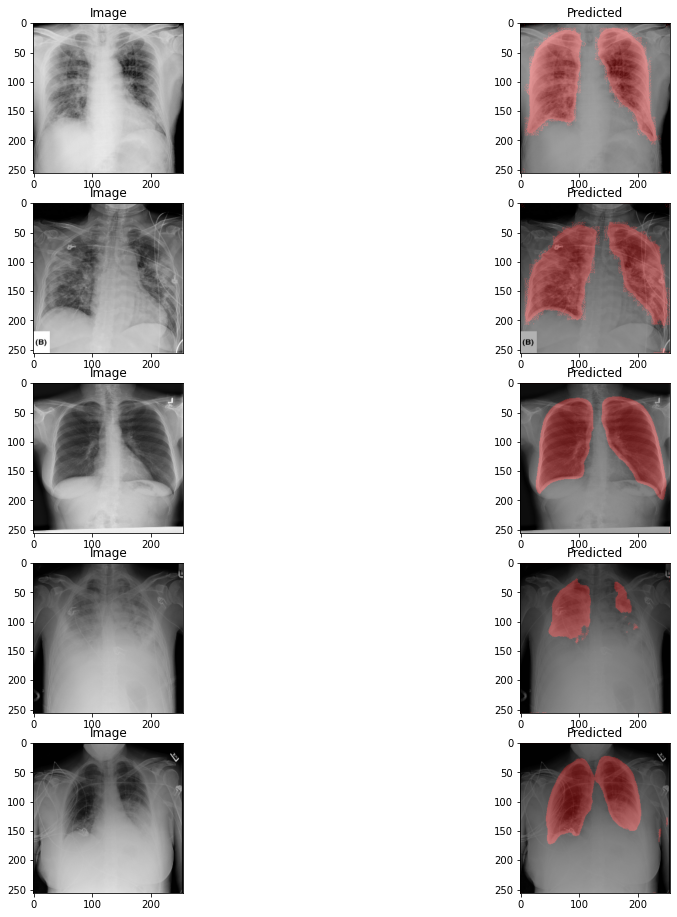

In [8]:
image = cv2.imread("./test/covidxray2.jpeg")
predict_image = cv2.imread("./test/pred/covidxray2_predict.jpeg")
#print(predict_image.shape)
image = cv2.resize(image, (256, 256))

fig, axs = plt.subplots(5,2 , figsize=(16, 16))

axs[0, 0].set_title("Image")
axs[0, 0].imshow(image)
axs[0, 1].set_title("Predicted")
axs[0, 1].imshow(add_colored_mask(image, predict_image))


image = cv2.imread("./test/covidxray.jpg")
predict_image = cv2.imread("./test/pred/covidxray_predict.jpg")

image = cv2.resize(image, (256, 256))

axs[1, 0].set_title("Image")
axs[1, 0].imshow(image)
axs[1, 1].set_title("Predicted")
axs[1, 1].imshow(add_colored_mask(image, predict_image))

image = cv2.imread("./test/pneuxray1.png")
predict_image = cv2.imread("./test/pred/pneuxray1_predict.png")

image = cv2.resize(image, (256, 256))

axs[2, 0].set_title("Image")
axs[2, 0].imshow(image)
axs[2, 1].set_title("Predicted")
axs[2, 1].imshow(add_colored_mask(image, predict_image))

image = cv2.imread("./test/pneuxray2.png")
predict_image = cv2.imread("./test/pred/pneuxray2_predict.png")

image = cv2.resize(image, (256, 256))

axs[3, 0].set_title("Image")
axs[3, 0].imshow(image)
axs[3, 1].set_title("Predicted")
axs[3, 1].imshow(add_colored_mask(image, predict_image))

image = cv2.imread("./test/pneuxray3.png")
predict_image = cv2.imread("./test/pred/pneuxray3_predict.png")

image = cv2.resize(image, (256, 256))

axs[4, 0].set_title("Image")
axs[4, 0].imshow(image)
axs[4, 1].set_title("Predicted")
axs[4, 1].imshow(add_colored_mask(image, predict_image))